# Overview
In this book, I build a person vs robot detector based on hand-built custom dataset using both Yolov5 and the Detectron2 implementation of Faster RCNN.

# YOLO5

## Installing Dependencies

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

%cd /content/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 KB 12.3 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
/content/yolov5


In [ ]:
import torch
from IPython.display import Image  # for displaying images
# from utils.google_utils import gdrive_download

# check which gpu is provided by google
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
! pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Downloading the dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="AVTlVhzQ74j8nTZMUzWk")
project = rf.workspace("innopolis-university-mt8jm").project("innopolis-detector")
dataset = project.version(7).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Innopolis-Detector-7 in yolov5pytorch:: 100%|██████████| 682/682 [00:01<00:00, 538.50it/s]


## Visualizing samples of the dataset
Before Delving into building models, let's take a look on the dataset. Here is a random sample of the original images

In [ ]:
import os
import numpy as np
import cv2
import random
random.seed(69)
from google.colab.patches import cv2_imshow


def plot_images(imgs_paths, new_size=None):
  # iteratte through all images
  for path in imgs_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # if the new_size parameter is set, then change the size of the image 
    # and display it
    if new_size is not None:
      img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    cv2_imshow(img)

current directory: /content/yolov5


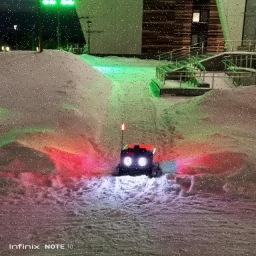

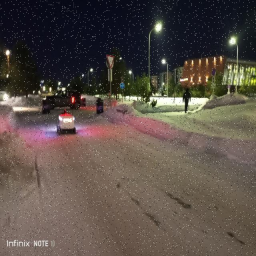

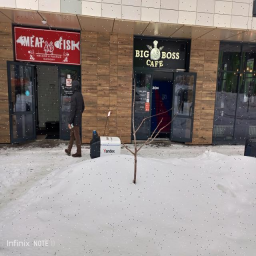

In [ ]:
# let's see a sample of the training dataset

print(f"current directory: {os.getcwd()}")
data_location = os.path.join('Innopolis-Detector-7')
train_images_loc = os.path.join(data_location, 'train', 'images')

# let's set the full paths of the images
train_images_paths = [os.path.join(train_images_loc, file_name) for file_name in os.listdir(train_images_loc)]

random_images = random.sample(train_images_paths, k=3)

plot_images(random_images, new_size=(256, 256))

In [ ]:
!pip install -Uqq ipdb # for debugging purposes

In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


As I found no ready-to-use functionalities to display the ground-truth bounding boxes, I had to write my own.

In [ ]:
import random
random.seed(11)

def read_image_label_yolo5(text_path):
  """
  This function extracts the bounding box parameters according to the Yolov5 format. Please refer to the following link:
  https://roboflow.com/formats/yolov5-pytorch-txt
  """
  with open(text_path, 'r') as f: 
    splits = [l[:-1].split() for l in f.readlines()]
    # ipdb.set_trace(context=6)
    boxes = [{"class": int(s[0]), "x": float(s[1]), "y": float(s[2]), "width": float(s[3]), "height": float(s[4])} for s in splits]
    # ipdb.set_trace(context=6)

  return boxes


def visualize_bounding_boxes(initial_image, bounding_boxes: dict):
  """
  initial_image: Image object read by cv2
  
  bounding_boxes: an iterable of dictionary object where each dictionary 
  is assumed to have the same elements as the ones generated by read_image_label_yolo5

  """
  image_shape = np.asarray(initial_image).shape
  print(image_shape)
  for b in bounding_boxes:
    # denormalize the values by multiplying the values by the corresponding
    # images' dimensions

    center_x = b['x'] * image_shape[0]
    center_y = b['y'] * image_shape[1]
    width = b['width'] * image_shape[0] 
    height = b['height'] * image_shape[1]

    x0 = center_x - width / 2
    x1 = center_x + width / 2
    
    y0 = center_y - height / 2
    y1 = center_y + height / 2

    # add a breakpoint
    # ipdb.set_trace(context=6)
    start_point = start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))
    # the color of the box should depend on the class of the object
    box_color = (0, 255, 0) if b['class'] == 0 else (255, 0, 0)
    cv2.rectangle(initial_image, start_point, end_point, color=box_color, thickness=2)
  
  cv2_imshow(initial_image)


def plot_bounding_boxes(roboflow_directory: str, n_samples: int):
  """Given the directory, create visualize the bounding boxes of a random set of images"""
  # the directory is assumed to follow the roboflow dataset architecture
  images_dir = os.path.join(roboflow_directory, 'images') # directory for images
  labels_dir = os.path.join(roboflow_directory, 'labels') # directory for labels
  # ipdb.set_trace(context=6)

  images_and_labels = list(zip(sorted(os.listdir(images_dir)), sorted(os.listdir(labels_dir))))
  # ipdb.set_trace(context=6)

  # take a random sample of the created list
  random_sample = random.sample(images_and_labels, k=n_samples)
  
  for img_name, label_file in random_sample: 
    # extract the dictionary with the exact coordinates
    boxes = read_image_label_yolo5(os.path.join(labels_dir, label_file))
    # read the image using cv2
    img = cv2.imread(os.path.join(images_dir, img_name))
    visualize_bounding_boxes(img, boxes)



(640, 640, 3)


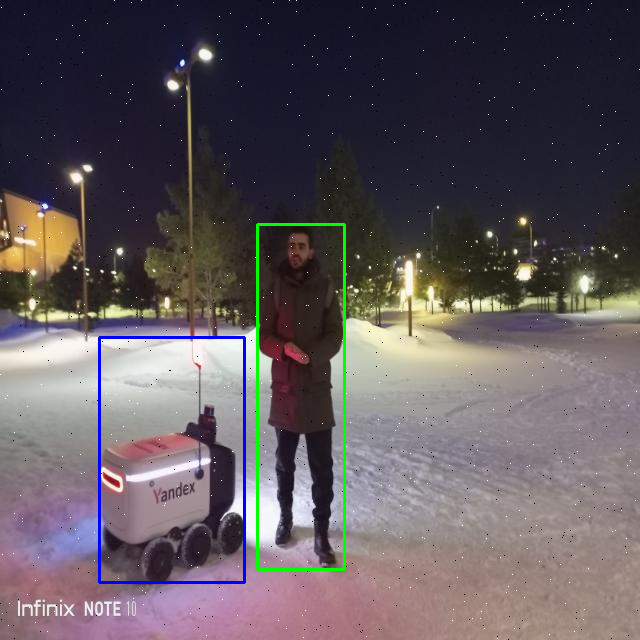

(640, 640, 3)


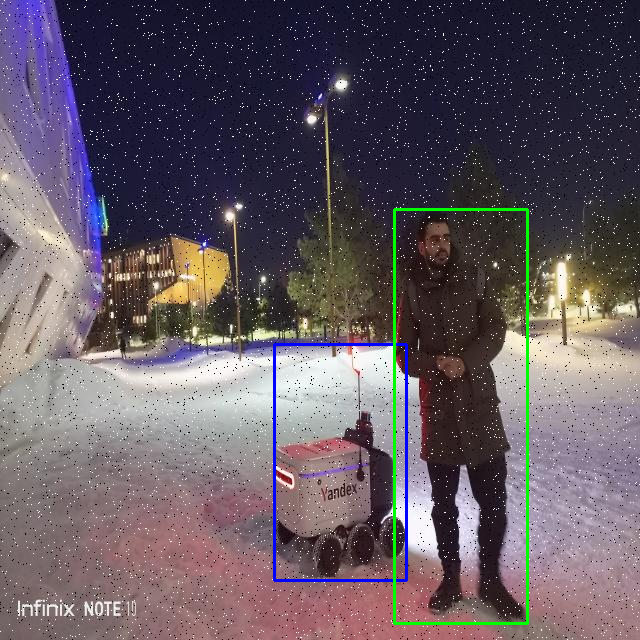

(640, 640, 3)


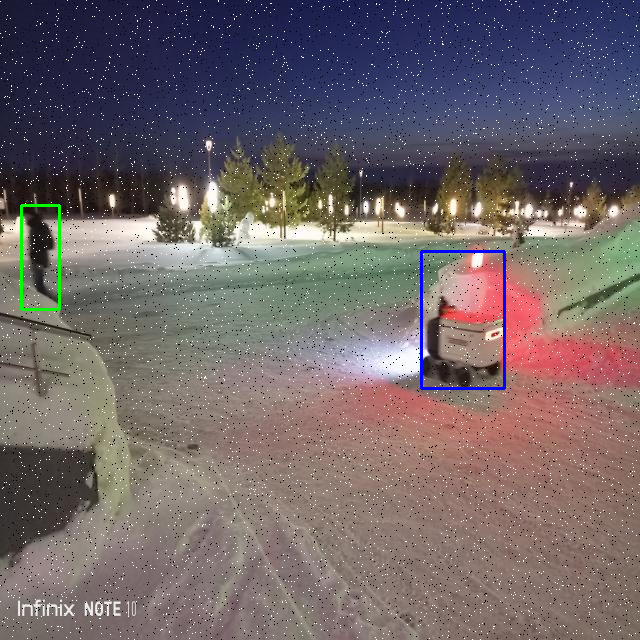

In [ ]:
# let's see our bounding boxes
train_directory = os.path.join(data_location, 'train')
plot_bounding_boxes(train_directory, n_samples=3,)

## Train Yolo5

In [ ]:
# define a file-management variable for further use
import os
HOME = r'/content'
print(HOME)

/content


In [ ]:
# train the mode
!python train.py --img 640 --batch 32 --epochs  25 --data {dataset.location}/data.yaml --weights yolov5n.pt --cache

train: weights=yolov5n.pt, cfg=, data=/content/yolov5/Innopolis-Detector-7/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

In [ ]:
# let's take a look on the training results
! ls {HOME}/'yolov5'/runs/train/exp4

confusion_matrix.png				    R_curve.png
events.out.tfevents.1678101036.b4b22d7ca831.4813.0  results.csv
F1_curve.png					    results.png
hyp.yaml					    train_batch0.jpg
labels_correlogram.jpg				    train_batch1.jpg
labels.jpg					    train_batch2.jpg
opt.yaml					    val_batch0_labels.jpg
P_curve.png					    val_batch0_pred.jpg
PR_curve.png					    weights


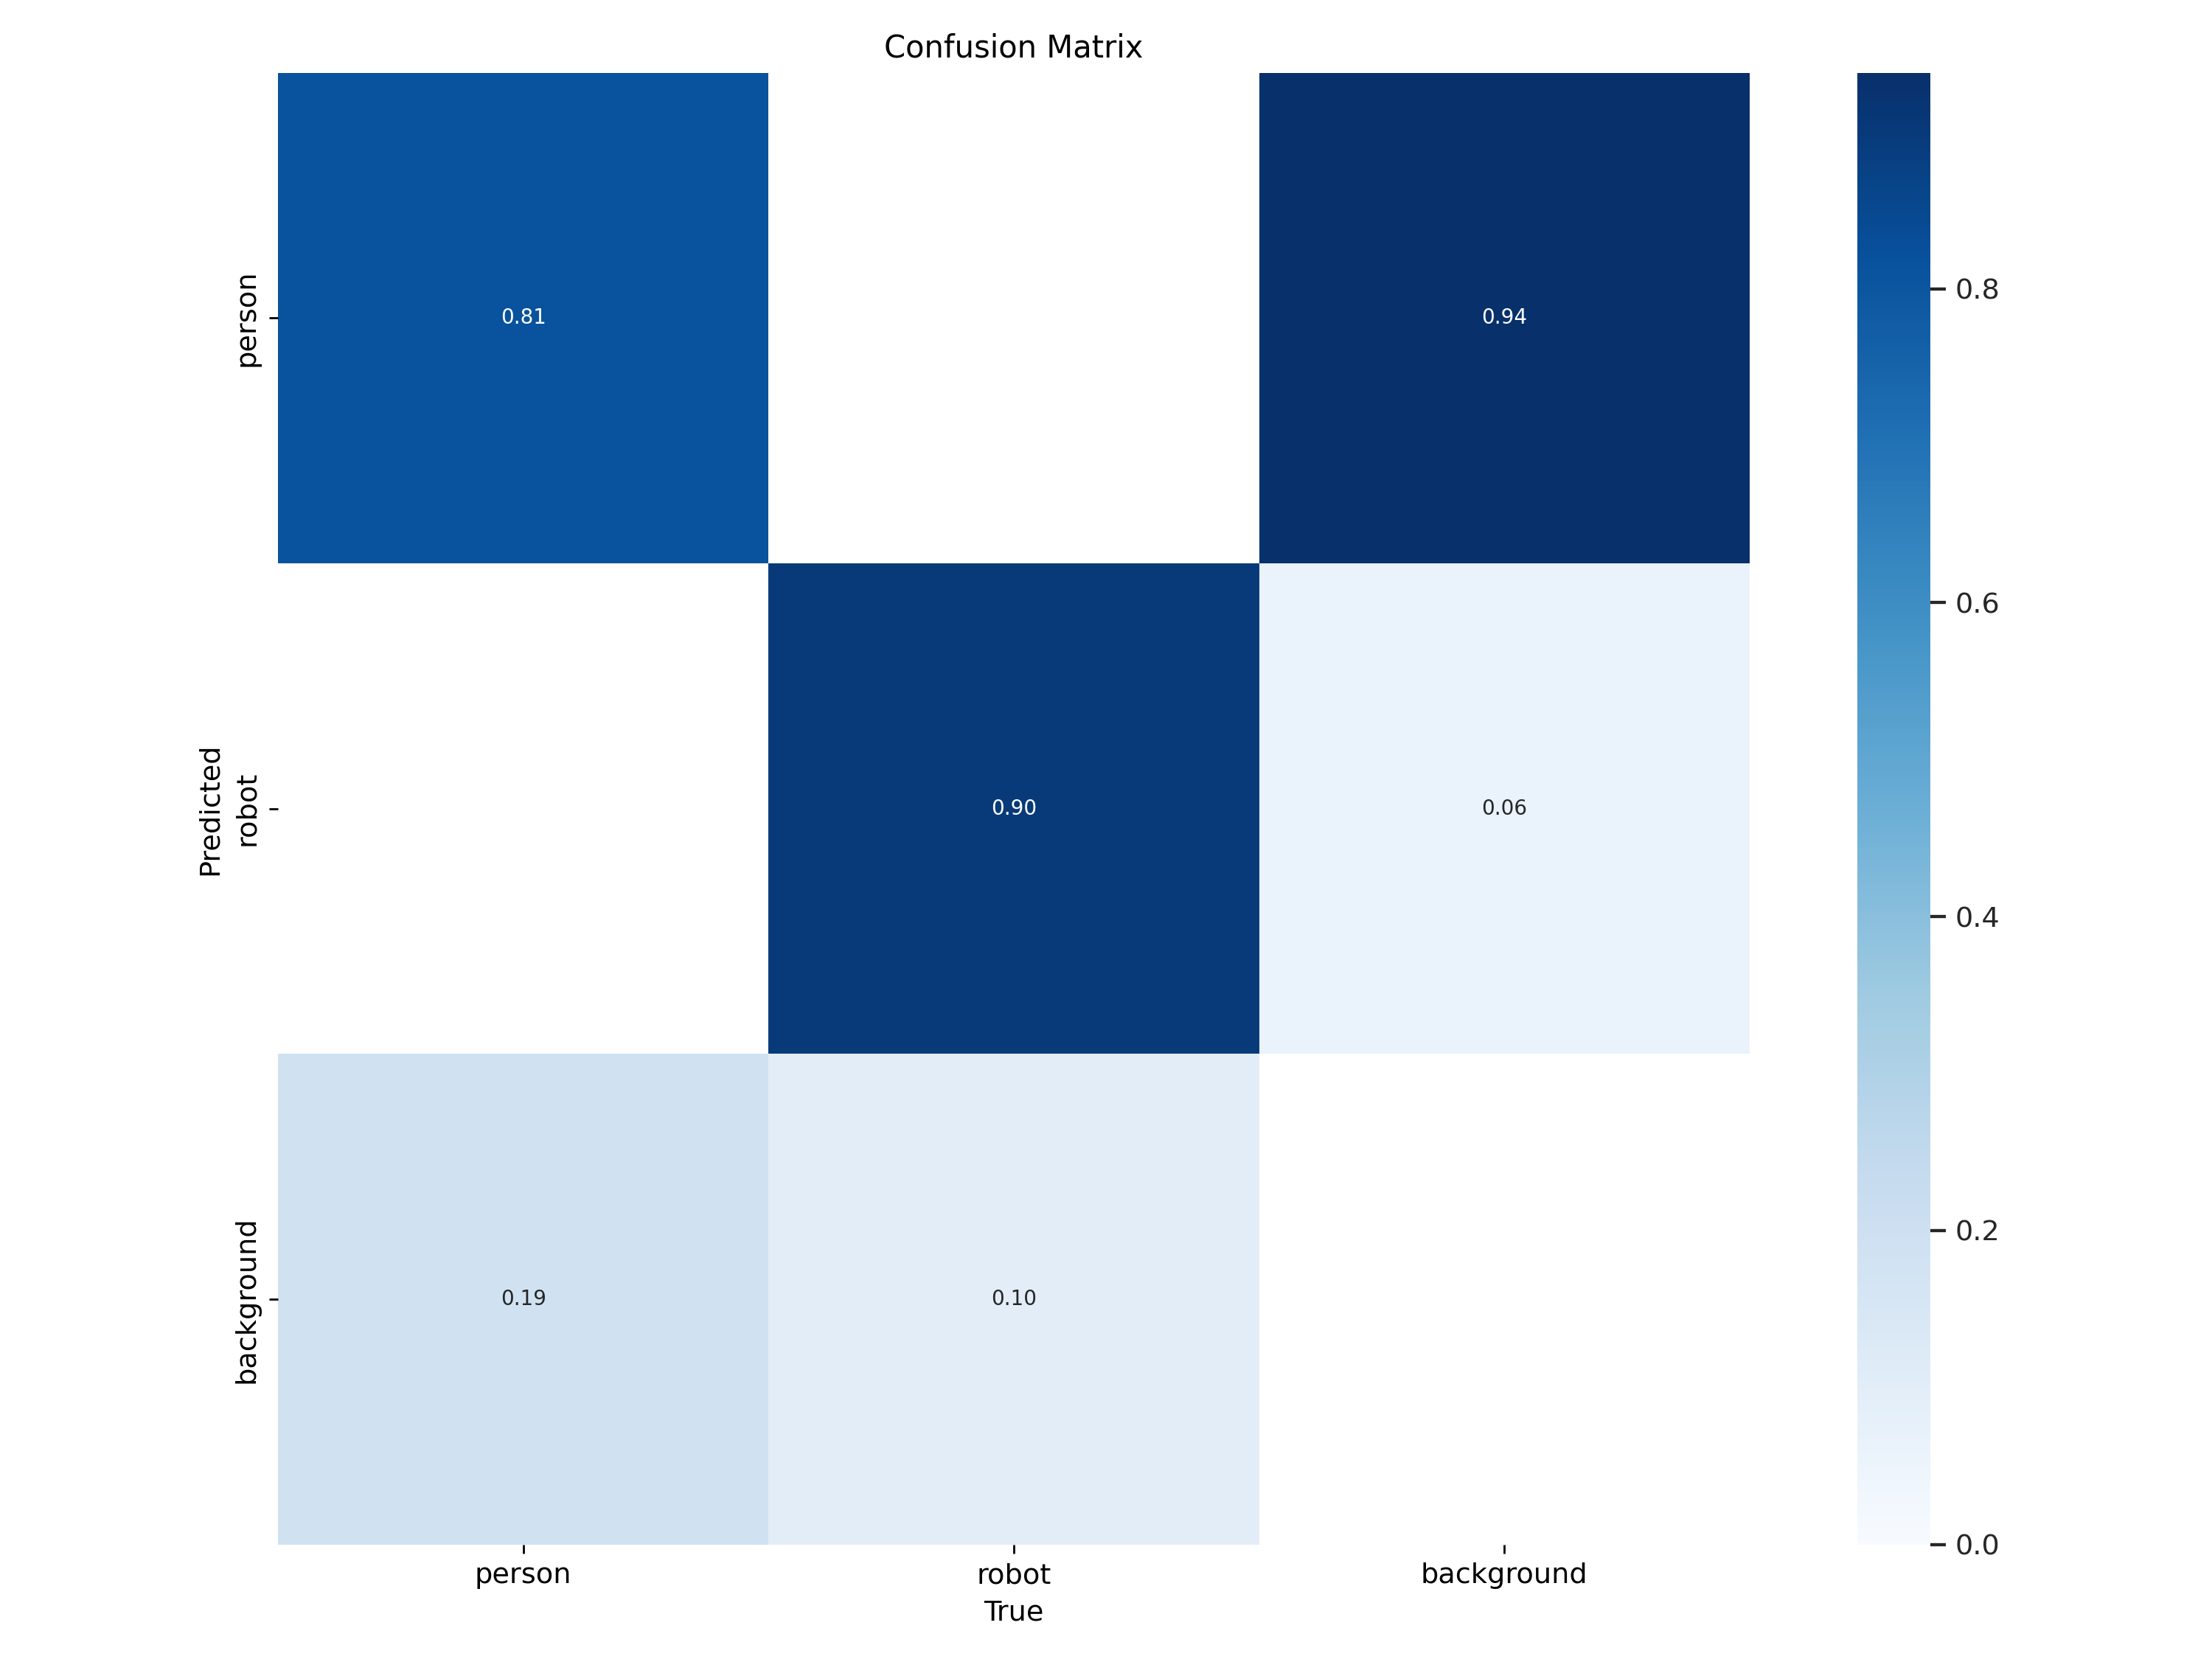

In [ ]:
# let's display the confusion matrix
Image(filename=f'{HOME}/yolov5/runs/train/exp4/confusion_matrix.png', width=600)

* The model differentiates well between robots and humans. It does not predict a **PERSON** as a **ROBOT**. And it mistakes **Robot** for a **PERSON**, only around $10\%$ of the time.
* The model still cannot detect the PERSON class well enough. This might be explainable by the nature of the dataset. Most images in the dataset capture both humans and robots. Geographically, these interactions take place usually in specific places (next to certain restaurants, the sport complex...)  
One possible solution is to increase the instances of the PERSON class in the dataset. 

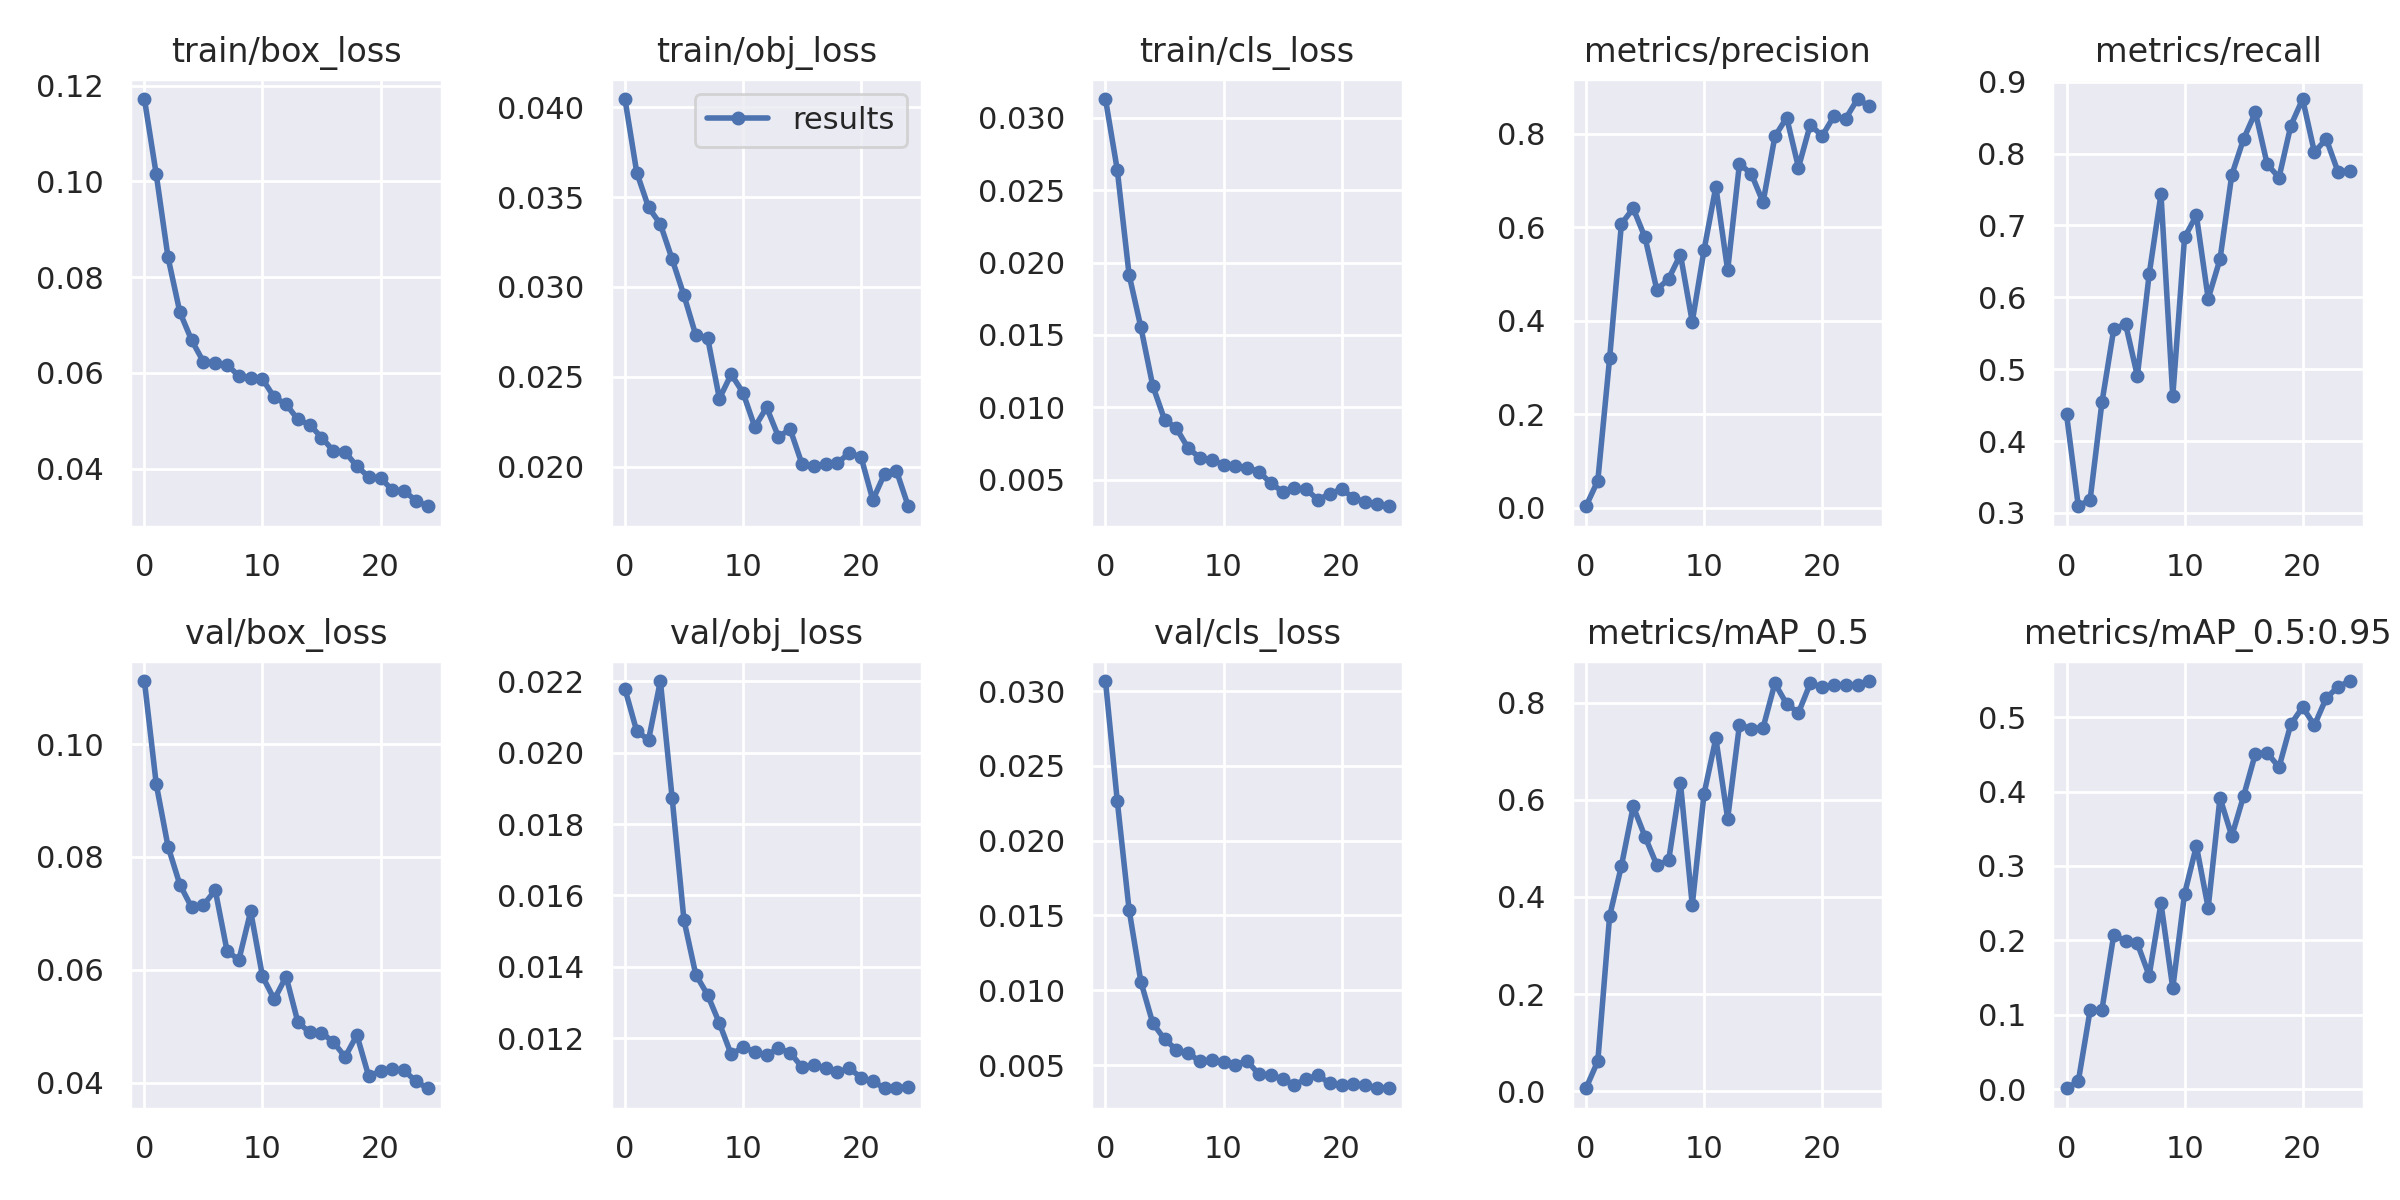

In [ ]:
# let's visualize the training results
Image(filename=f'{HOME}/yolov5/runs/train/exp4/results.png', width=600)

Let's analyse the following:
1. box_loss: At the end of the training, The **train loss** is relatively higher than the **validation loss**. However, the significance of such difference depends mainly on the performance objectives.
2. obj_loss: At the end of the training, the **validation loss** is smaller than the **train loss**. 
3. the cls losses are almost equivalent for both datasets.

The model is definitely not underfitting the problem in hand. As the current dataset is quite small, More data is likely to help reduce possible overfitting.

In [ ]:
# time to see how the model works on the test part of the dataset
%cd '{HOME}/yolov5'
!python val.py --weights runs/train/exp4/weights/best.pt --img 640 --conf 0.7 --data {dataset.location}/data.yaml

/content/yolov5
val: data=/content/yolov5/Innopolis-Detector-7/data.yaml, weights=['runs/train/exp4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.7, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.7 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /content/yolov5/Innopolis-Detector-7/valid/labels.cache... 25 images, 0 backgrounds, 0 corrupt: 100% 25/25 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.87s/it]
                   all         25         57      0.906      0.641      0.785       0.57


Metrics Evaluation:
1. The model performs relatively well on the test dataset.
2. The remarks derived from the confusion matrix are further supported by the model's performance on class **PERSON**: relatively low precision. The latter affects significantly: 0.47 
3. The model seems to have higher success with the robot class: 0.67
4. The final MAP is 0.57 which is relatively high
5. Inference time: 6.6ms per image
6. A size of: 28.5 megebytes

# Faster-RCNN

## Installing dependencies

In [ ]:
# let's reset the current working directory before proceeding
%cd ../

[Errno 2] No such file or directory: 'content'
/content


In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=ef487235853131805d65a4acf904568dd0c9c90ac7cb4b2d4be1bbce45e942e5
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14867, done.
remote: Cou

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
# getting the dataset
!curl -L "https://app.roboflow.com/ds/JIz0Eu7yOk?key=XZ4Fd8m0x7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0   3291      0 --:--:-- --:--:-- --:--:--  3291
100 29.2M  100 29.2M    0     0  45.7M      0 --:--:-- --:--:-- --:--:-- 45.7M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/IMG_20230228_152342_010_jpg.rf.a52e9f0df51f4dfb3a319b2f37d33b28.jpg  
 extracting: test/IMG_20230228_152412_961_jpg.rf.3b13b1cd916fc429962af9acfa72665c.jpg  
 extracting: test/IMG_20230228_152909_834_jpg.rf.39d8e650bd31881cb8472b122eef91f7.jpg  
 extracting: test/IMG_20230301_163754_683_jpg.rf.04fe80aebec2bf73163d54c478262b8b.jpg  
 extracting: test/IMG_20230301_163755_675_jpg.rf.930533ed0fa3c7d59a37994804914b13.jpg  
 extracting: test/IMG_20230301_163757_302_jpg.rf.ad5e53b4327319e2589653b589dc7885.jpg  
 extracting: test/IMG_20230301_175549_

In [5]:
# registering directly as it is in COCO format
from detectron2.data.datasets import register_coco_instances
register_coco_instances("innopolis_detector_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("innopolis_detector_valid", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("innopolis_detector_test", {}, "/content/test/_annotations.coco.json", "/content/test")


In [6]:
from detectron2.engine import DefaultTrainer

ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
MODEL = f"COCO-Detection/{ARCHITECTURE}.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = ("innopolis_detector_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 400    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/06 19:27:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:07, 53.9MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/06 19:28:10 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/06 19:28:48 d2.utils.events]:  eta: 0:09:42  iter: 19  total_loss: 2.339  loss_cls: 1.348  loss_box_reg: 1.002  loss_rpn_cls: 0.02617  loss_rpn_loc: 0.008419  time: 1.4736  last_time: 1.5563  data_time: 0.0247  last_data_time: 0.0055   lr: 4.8453e-05  max_mem: 4232M
[03/06 19:29:19 d2.utils.events]:  eta: 0:09:11  iter: 39  total_loss: 1.834  loss_cls: 0.8329  loss_box_reg: 0.9462  loss_rpn_cls: 0.02595  loss_rpn_loc: 0.01066  time: 1.4917  last_time: 1.4528  data_time: 0.0111  last_data_time: 0.0057   lr: 9.8403e-05  max_mem: 4232M
[03/06 19:29:48 d2.utils.events]:  eta: 0:08:26  iter: 59  total_loss: 1.597  loss_cls: 0.5627  loss_box_reg: 0.9718  loss_rpn_cls: 0.01103  loss_rpn_loc: 0.009341  time: 1.4793  last_time: 1.5760  data_time: 0.0137  last_data_time: 0.0072   lr: 0.00014835  max_mem: 4232M
[03/06 19:30:18 d2.utils.events]:  eta: 0:07:56  iter: 79  total_loss: 1.406  loss_cls: 0.4523  loss_box_reg: 0.9553  loss_rpn_cls: 0.01088  loss_rpn_loc: 0.009302  time: 1.4830  last_

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/06 19:38:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [8]:
# let's evaluate the model on the test dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("innopolis_detector_test", cfg, False, output_dir="output")
val_loader = build_detection_test_loader(cfg, "innopolis_detector_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/06 19:38:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[03/06 19:38:27 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/06 19:38:27 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/06 19:38:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 19:38:27 d2.data.datasets.coco]: Loaded 25 images in COCO format from /content/test/_annotations.coco.json
[03/06 19:38:27 d2.data.build]: Distribution of instances among all 3 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| person-robot | 0            |   person   | 22           |   robot    | 25           |


OrderedDict([('bbox',
              {'AP': 69.87130164927787,
               'AP50': 88.6070059595673,
               'AP75': 84.85582003016354,
               'APs': 80.0,
               'APm': 59.42845355964168,
               'APl': 74.92598286169925,
               'AP-person-robot': nan,
               'AP-person': 73.55777671356411,
               'AP-robot': 66.18482658499161})])

WARNING [03/06 19:38:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/06 19:38:32 d2.data.datasets.coco]: Loaded 25 images in COCO format from /content/valid/_annotations.coco.json
{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[379.3160, 298.1797, 522.4111, 439.5990],
        [496.2999, 180.6312, 637.1815, 521.2445],
        [589.1906, 280.3445, 640.0000, 635.8171]], device='cuda:0')), scores: tensor([0.9782, 0.9745, 0.9287], device='cuda:0'), pred_classes: tensor([2, 1, 1], device='cuda:0')])}


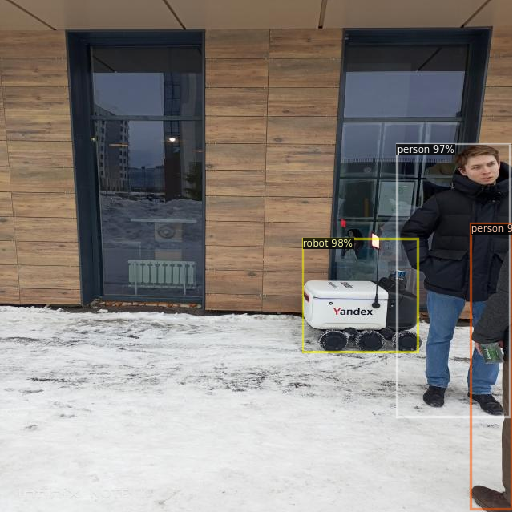

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[279.8792, 258.3664, 350.9076, 397.2409],
        [377.9154, 264.9328, 414.2242, 341.4686]], device='cuda:0')), scores: tensor([0.9715, 0.9467], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


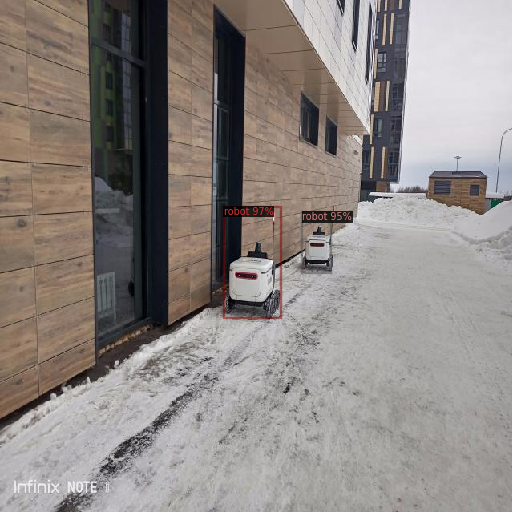

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 59.4594, 280.5095, 214.2970, 515.5507]], device='cuda:0')), scores: tensor([0.9834], device='cuda:0'), pred_classes: tensor([2], device='cuda:0')])}


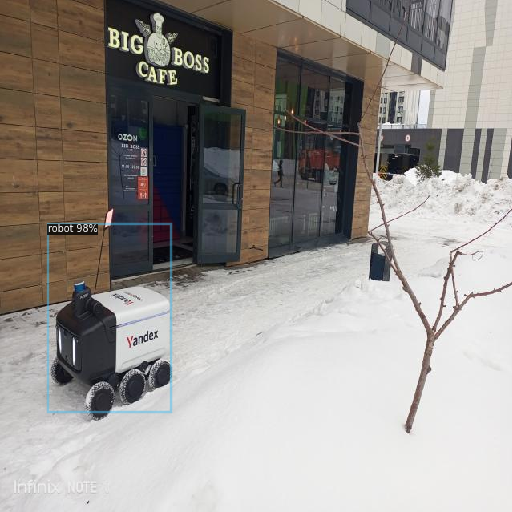

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 53.6131, 309.1986, 217.2376, 562.6012],
        [299.7004, 138.7861, 445.8660, 597.5399],
        [427.6871, 148.1038, 566.0432, 640.0000]], device='cuda:0')), scores: tensor([0.9898, 0.9861, 0.9822], device='cuda:0'), pred_classes: tensor([2, 1, 1], device='cuda:0')])}


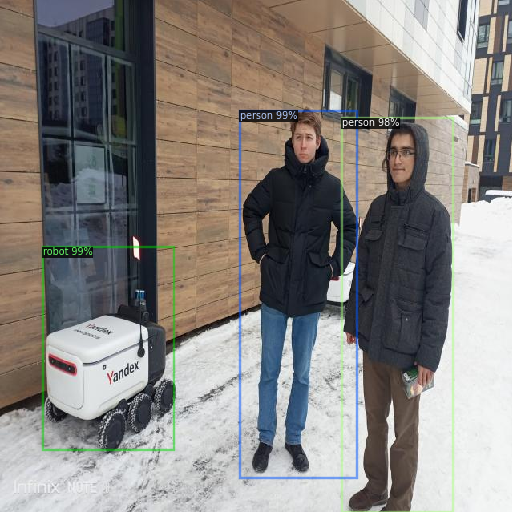

{'instances': Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[167.2923,  75.7124, 266.9813, 524.2294],
        [412.4836, 230.0038, 499.8297, 373.2971],
        [ 21.9897, 229.6263, 161.3371, 435.8162],
        [221.2637,  81.0701, 336.4953, 626.5327]], device='cuda:0')), scores: tensor([0.9849, 0.9828, 0.9797, 0.9791], device='cuda:0'), pred_classes: tensor([1, 2, 2, 1], device='cuda:0')])}


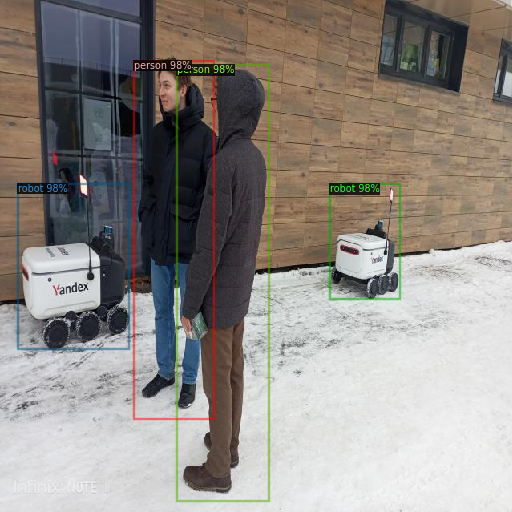

In [9]:
metadata = MetadataCatalog.get('innopolis_detector_train')
dataset_valid = DatasetCatalog.get('innopolis_detector_valid')
count = 0
for d in dataset_valid:
    count += 1
    img = cv2.imread(d['file_name'])
    outputs = predictor(img)
    print(outputs)
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata, 
        scale=0.8
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    if count >= 5: break 


The faster RCNN performs quite well on the problem at hand.
* MAP: 0.698 
* Inference time: 0.1926s
* Size: 6.7 Gigabytes 

# Models Comparison
YOLOV5 (the nano model) VS FASTER RCNN:
1. Mean Average Precision: 0.47 VS 0.698
2. Inference time: 192 ms VS 6.6 ms
3. Memory Requirements: 28.5 MB VS 6.7 GB

Even though Faster RCNN outperforms Yolov5 in Mean Average Precision, The boost in performance introduced by Faster RCNN might not be proportional to memory requirements and inference speed especially with Yolov5 (the nano model) is quite likely to be improved with a larger training dataset and more data augmentation techniques. 